In [1]:
# JupyterLab / Notebook interactive backend
%load_ext ipympl
%matplotlib widget


The ipympl module is not an IPython extension.


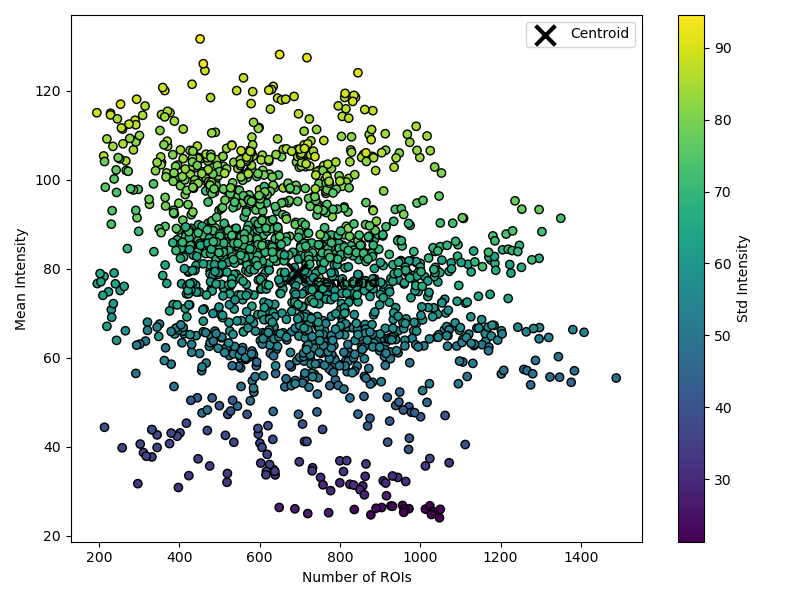

In [2]:
import os
import csv
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt

# ────────────────────────────────────────────────────────────────────────
# CONFIGURATION
# ────────────────────────────────────────────────────────────────────────
BASE_DIR        = r'D:\Results\Interactive_figures\Stitched_sixteenth'
CSV_NAME        = 'results.csv'
CSV_PATH        = os.path.join(BASE_DIR, CSV_NAME)

# Your precomputed centroid:
CENTROID_ROIS   = 694.49
CENTROID_MEAN   = 79.0141
# ────────────────────────────────────────────────────────────────────────

def _to_float(x):
    try:
        return float(x)
    except Exception:
        return np.nan

def load_csv_rows(csv_path):
    """
    Returns (images: list[str], num_rois: np.ndarray, mean: np.ndarray, std: np.ndarray)
    Filters out rows with NaNs so array indices align.
    """
    images, xs, ys, cs = [], [], [], []
    with open(csv_path, newline='', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        # Expected columns: image, num_rois, mean_intensity, std_intensity
        for row in reader:
            img = row.get('image', '')
            x   = _to_float(row.get('num_rois', ''))
            y   = _to_float(row.get('mean_intensity', ''))
            c   = _to_float(row.get('std_intensity', ''))
            if img and np.isfinite(x) and np.isfinite(y) and np.isfinite(c):
                images.append(img)
                xs.append(x); ys.append(y); cs.append(c)
    return images, np.asarray(xs), np.asarray(ys), np.asarray(cs)

def plot_interactive(csv_path, centroid_rois, centroid_mean, hover_px=8.0):
    images, x, y, c = load_csv_rows(csv_path)

    fig, ax = plt.subplots(figsize=(8, 6))
    sc = ax.scatter(x, y, c=c, cmap='viridis', edgecolors='k')
    cbar = fig.colorbar(sc, ax=ax)
    cbar.set_label('Std Intensity')

    # Centroid
    ax.scatter([centroid_rois], [centroid_mean], marker='x', s=200,
               c='black', linewidths=3, label='Centroid')
    ax.annotate('Centroid',
                xy=(centroid_rois, centroid_mean),
                xytext=(10, -10), textcoords='offset points',
                color='black', fontsize=10, fontweight='bold')

    ax.set_xlabel('Number of ROIs')
    ax.set_ylabel('Mean Intensity')
    ax.legend(loc='upper right')
    fig.tight_layout()

    # Tooltip annotation (initially hidden)
    annot = ax.annotate(
        "", xy=(0, 0), xytext=(10, 10), textcoords="offset points",
        bbox=dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9),
        arrowprops=dict(arrowstyle="->")
    )
    annot.set_visible(False)

    # We’ll build a KD-tree in display (pixel) coordinates for fast hover lookup
    tree = None
    disp_xy = None

    def build_tree(event=None):
        nonlocal tree, disp_xy
        # Transform data coords -> display (pixel) coords
        data_xy = np.column_stack((x, y))
        disp_xy = ax.transData.transform(data_xy)
        tree = cKDTree(disp_xy)

    def on_draw(event):
        # Recompute the KD-tree whenever the figure is drawn (resize, zoom, etc.)
        build_tree()

    def on_move(event):
        if tree is None or not event.inaxes:
            if annot.get_visible():
                annot.set_visible(False)
                fig.canvas.draw_idle()
            return
        if event.x is None or event.y is None:
            return

        # Query nearest point in pixel space
        dist, idx = tree.query([event.x, event.y], k=1)
        if np.isfinite(dist) and dist <= hover_px:
            # Update annotation
            px, py = x[idx], y[idx]
            annot.xy = (px, py)
            annot.set_text(str(images[idx]))
            if not annot.get_visible():
                annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if annot.get_visible():
                annot.set_visible(False)
                fig.canvas.draw_idle()

    # Initial tree, then connect events
    build_tree()
    cid_draw = fig.canvas.mpl_connect('draw_event', on_draw)
    cid_move = fig.canvas.mpl_connect('motion_notify_event', on_move)

    return fig, ax

fig, ax = plot_interactive(CSV_PATH, CENTROID_ROIS, CENTROID_MEAN)



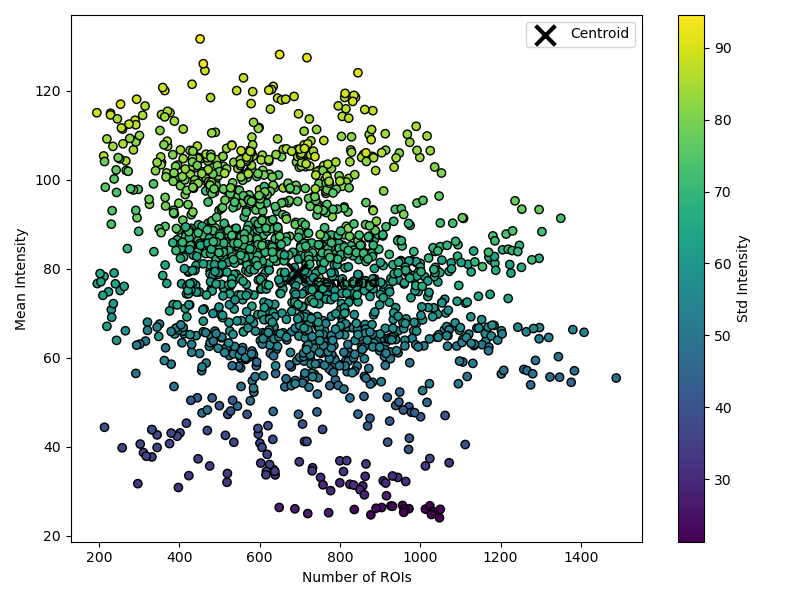

In [3]:
#| label: fig:scatter-plot
#| caption: "_."
plt.show()